# Resulting probabilities with time

## Notebook setup

In [18]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import stroke_outcome.outcome_utilities

In [56]:
dir_output = 'output'
dir_images = 'images'

In [5]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
# plt.style.use('seaborn-colorblind')

## Import data

Cumulative probabilities, $P(\mathrm{mRS}\leq x))$:

In [9]:
mrs_cprob_all, mrs_dists_notes = (
    stroke_outcome.outcome_utilities.import_mrs_dists_from_file())

mrs_cprob_all

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
Stroke type,,,,,,,
pre_stroke_nlvo,0.583,0.746,0.850,0.951,0.993,1.000,1
pre_stroke_lvo,0.408,0.552,0.672,0.838,0.956,1.000,1
no_treatment_lvo,0.050,0.129,0.265,0.429,0.676,0.811,1
no_treatment_nlvo,0.198,0.460,0.580,0.708,0.856,0.918,1
no_effect_nlvo_ivt_deaths,0.196,0.455,0.574,0.701,0.847,0.908,1
no_effect_lvo_ivt_deaths,0.048,0.124,0.255,0.414,0.653,0.783,1
no_effect_lvo_mt_deaths,0.048,0.124,0.255,0.412,0.649,0.779,1
t0_treatment_nlvo_ivt,0.445,0.642,0.752,0.862,0.941,0.967,1
t0_treatment_lvo_ivt,0.140,0.233,0.361,0.522,0.730,0.838,1


## Calculate probabilities with time

Define functions to save repeating code:

In [29]:
def make_logodds_from_probs(mrs_cprob_all, data_name):
    # Pick out the requested data:
    mrs_cprob = mrs_cprob_all.loc[data_name].values
    # Convert probabilities to odds:
    mrs_odds_cumsum = mrs_cprob / (1.0 - mrs_cprob)
    # Manually set mRS<=6 values to infinity, since P(mRS<=6)=1:
    mrs_odds_cumsum[-1] = np.inf 
    # Convert odds to log-odds:
    mrs_logodds_cumsum = np.log(mrs_odds_cumsum)
    return mrs_logodds_cumsum

In [30]:
def make_probs_with_time(mrs_cprob_all, t0_st, ne_st, t_ne):
    # Convert time-zero and no-effect probabilities to log-odds:
    t0_logodds = make_logodds_from_probs(mrs_cprob_all, t0_st)
    no_effect_logodds = make_logodds_from_probs(mrs_cprob_all, ne_st)

    # Calculate probabilities over this time range:
    t = np.arange(0, t_ne*60.0 + 0.1, 0.1)
    # Round the data to remove floating point error:
    t = np.round(t, 1)

    # Reshape the arrays to allow for multiple treatment times.
    time_to_treatment_mins = t.reshape(len(t), 1)
    no_effect_logodds = no_effect_logodds.reshape(1, len(no_effect_logodds))
    t0_logodds = t0_logodds.reshape(1, len(t0_logodds))

    treated_probs, treated_odds, treated_logodds = (
        stroke_outcome.outcome_utilities.calculate_mrs_dist_at_treatment_time(
            time_to_treatment_mins = time_to_treatment_mins,
            time_no_effect_mins = t_ne * 60.0,
            t0_logodds = t0_logodds,
            no_effect_logodds = no_effect_logodds,
            final_value_is_mrs6 = True
            ))
    
    # Only store the probabilities.
    # Round to 5 decimal places, should be plenty:
    treated_probs = np.round(treated_probs, 5)

    df_probs = pd.DataFrame(
        treated_probs,
        columns=[f'mRS<={i}' for i in range(7)],
        index=t
    )
    df_probs.index.name = 'treatment_time_mins'
    return df_probs

Calculate the probabilities with time:

In [31]:
df_probs_nlvo_ivt = make_probs_with_time(
    mrs_cprob_all,
    't0_treatment_nlvo_ivt',
    'no_effect_nlvo_ivt_deaths',
    t_ne=6.3
)

/tmp/ipykernel_29075/1764391557.py:4: RuntimeWarning: divide by zero encountered in divide
  mrs_odds_cumsum = mrs_cprob / (1.0 - mrs_cprob)
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:688: RuntimeWarning: invalid value encountered in multiply
  treated_logodds = ((frac_to_no_effect * no_effect_logodds) +
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:689: RuntimeWarning: invalid value encountered in multiply
  ((1 - frac_to_no_effect) * t0_logodds))
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:693: RuntimeWarning: invalid value encountered in divide
  treated_probs = treated_odds / (1 + treated_odds)


In [32]:
df_probs_lvo_ivt = make_probs_with_time(
    mrs_cprob_all,
    't0_treatment_lvo_ivt',
    'no_effect_lvo_ivt_deaths',
    t_ne=6.3
)

/tmp/ipykernel_29075/1764391557.py:4: RuntimeWarning: divide by zero encountered in divide
  mrs_odds_cumsum = mrs_cprob / (1.0 - mrs_cprob)
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:688: RuntimeWarning: invalid value encountered in multiply
  treated_logodds = ((frac_to_no_effect * no_effect_logodds) +
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:689: RuntimeWarning: invalid value encountered in multiply
  ((1 - frac_to_no_effect) * t0_logodds))
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:693: RuntimeWarning: invalid value encountered in divide
  treated_probs = treated_odds / (1 + treated_odds)


In [33]:
df_probs_lvo_mt = make_probs_with_time(
    mrs_cprob_all,
    't0_treatment_lvo_mt',
    'no_effect_lvo_mt_deaths',
    t_ne=8.0
)

/tmp/ipykernel_29075/1764391557.py:4: RuntimeWarning: divide by zero encountered in divide
  mrs_odds_cumsum = mrs_cprob / (1.0 - mrs_cprob)
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:688: RuntimeWarning: invalid value encountered in multiply
  treated_logodds = ((frac_to_no_effect * no_effect_logodds) +
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:689: RuntimeWarning: invalid value encountered in multiply
  ((1 - frac_to_no_effect) * t0_logodds))
/home/anna/miniconda3/lib/python3.9/site-packages/stroke_outcome/outcome_utilities.py:693: RuntimeWarning: invalid value encountered in divide
  treated_probs = treated_odds / (1 + treated_odds)


View the resulting dataframes:

In [34]:
df_probs_nlvo_ivt

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
treatment_time_mins,,,,,,,
0.0,0.44500,0.64200,0.75200,0.86200,0.94100,0.96700,1.0
0.1,0.44492,0.64195,0.75196,0.86197,0.94098,0.96699,1.0
0.2,0.44484,0.64191,0.75192,0.86194,0.94097,0.96698,1.0
0.3,0.44477,0.64186,0.75188,0.86191,0.94095,0.96697,1.0
0.4,0.44469,0.64181,0.75184,0.86188,0.94094,0.96696,1.0
...,...,...,...,...,...,...,...
377.6,0.19620,0.45520,0.57421,0.70122,0.84715,0.90810,1.0
377.7,0.19615,0.45515,0.57416,0.70116,0.84711,0.90807,1.0
377.8,0.19610,0.45510,0.57410,0.70111,0.84707,0.90805,1.0


In [35]:
df_probs_lvo_ivt

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
treatment_time_mins,,,,,,,
0.0,0.14000,0.23300,0.36100,0.52200,0.73000,0.83800,1.0
0.1,0.13996,0.23296,0.36097,0.52197,0.72998,0.83799,1.0
0.2,0.13993,0.23293,0.36094,0.52194,0.72996,0.83797,1.0
0.3,0.13989,0.23289,0.36091,0.52191,0.72994,0.83796,1.0
0.4,0.13985,0.23286,0.36088,0.52189,0.72992,0.83795,1.0
...,...,...,...,...,...,...,...
377.6,0.04806,0.12409,0.25510,0.41411,0.65309,0.78306,1.0
377.7,0.04804,0.12407,0.25508,0.41408,0.65307,0.78305,1.0
377.8,0.04803,0.12404,0.25505,0.41406,0.65304,0.78303,1.0


In [36]:
df_probs_lvo_mt

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
treatment_time_mins,,,,,,,
0.0,0.30600,0.42900,0.54800,0.70700,0.85100,0.91500,1.0
0.1,0.30590,0.42891,0.54793,0.70695,0.85097,0.91498,1.0
0.2,0.30581,0.42883,0.54787,0.70689,0.85094,0.91496,1.0
0.3,0.30571,0.42874,0.54780,0.70684,0.85091,0.91495,1.0
0.4,0.30562,0.42866,0.54774,0.70679,0.85088,0.91493,1.0
...,...,...,...,...,...,...,...
479.6,0.04808,0.12415,0.25520,0.41225,0.64921,0.77916,1.0
479.7,0.04806,0.12411,0.25515,0.41219,0.64916,0.77912,1.0
479.8,0.04804,0.12408,0.25510,0.41212,0.64911,0.77908,1.0


Save these to file:

In [37]:
df_probs_nlvo_ivt.to_csv(os.path.join(dir_output, 'probs_with_time_nlvo_ivt.csv'))

In [38]:
df_probs_lvo_ivt.to_csv(os.path.join(dir_output, 'probs_with_time_lvo_ivt.csv'))

In [39]:
df_probs_lvo_mt.to_csv(os.path.join(dir_output, 'probs_with_time_lvo_mt.csv'))

## Plot probabilities with time

Plot the lines in these colours:

In [6]:
colour_list = np.array([
    '#0072B2', '#009E73', '#D55E00', '#CC79A7',
    '#F0E442', '#56B4E9', 'DarkSlateGray'], dtype='<U13'
)

Version 1: just the lines

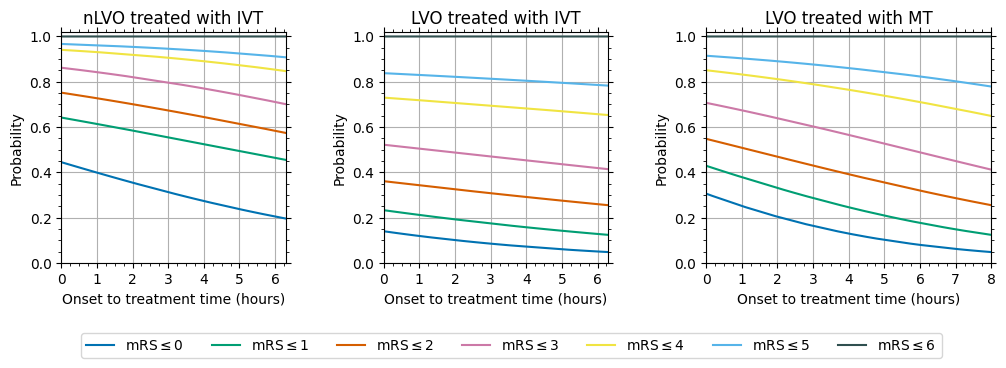

In [79]:
wr = 6.3 / 8.0

fig, axs = plt.subplots(1, 3, figsize=(12, 3), gridspec_kw={'wspace': 0.4, 'width_ratios': [wr, wr, 1]})

dfs = [df_probs_nlvo_ivt, df_probs_lvo_ivt, df_probs_lvo_mt]
titles = ['nLVO treated with IVT', 'LVO treated with IVT', 'LVO treated with MT']

for d, df in enumerate(dfs):
    ax = axs[d]

    # Convert minutes to hours:
    times = df.index.values / 60.0

    for i in range(7):
        probs = df[f'mRS<={i}']
        ax.plot(times, probs, color=colour_list[i], label=rf'mRS$\leq${i}')
    if d == 0:
        fig.legend(bbox_to_anchor=[0.5, -0.1], loc='upper center', ncol=7)

for d, ax in enumerate(axs):
    ax.set_ylim(0.0, 1.02)

    xmax = 6.3 if d < 2 else 8.0
    ax.set_xlim(0.0, xmax)
    ax.set_xticks(np.arange(0, xmax + 0.01))
    ax.set_xticks(np.arange(0.0, xmax + 0.01, 0.25), minor=True)

    ax.set_yticks(np.arange(0.0, 1.01, 0.05), minor=True)
    ax.tick_params(right=True, top=True, which='both')
    ax.grid('on')
    ax.set_xlabel('Onset to treatment time (hours)')
    ax.set_ylabel('Probability')
    ax.set_title(titles[d])

plt.savefig(os.path.join(dir_images, 'probs_with_time.png'), bbox_inches='tight')
plt.show()

Version 2: filled blocks

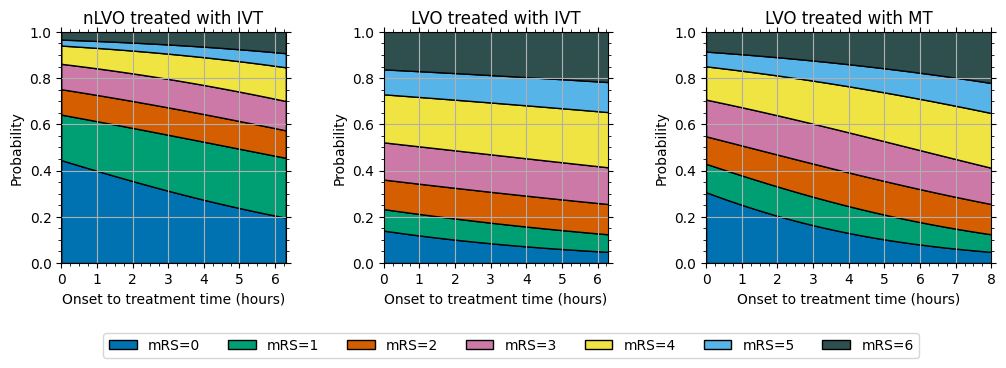

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), gridspec_kw={'wspace': 0.4, 'width_ratios': [wr, wr, 1]})

dfs = [df_probs_nlvo_ivt, df_probs_lvo_ivt, df_probs_lvo_mt]
titles = ['nLVO treated with IVT', 'LVO treated with IVT', 'LVO treated with MT']

for d, df in enumerate(dfs):
    ax = axs[d]

    # Convert minutes to hours:
    times = df.index.values / 60.0

    for i in range(7):
        probs = df[f'mRS<={i}']
        try:
            probs_before = df[f'mRS<={i-1}']
        except KeyError:
            probs_before = np.full(probs.size, 0.0)
        ax.fill_between(times, probs_before, probs, color=colour_list[i], edgecolor='k', label=f'mRS={i}')
    if d == 0:
        fig.legend(bbox_to_anchor=[0.5, -0.1], loc='upper center', ncol=7)

for d, ax in enumerate(axs):
    ax.set_ylim(0.0, 1.0)
    
    xmax = 6.3 if d < 2 else 8.0
    ax.set_xlim(0.0, xmax)
    ax.set_xticks(np.arange(0, xmax + 0.01))
    ax.set_xticks(np.arange(0.0, xmax + 0.01, 0.25), minor=True)
    
    ax.set_yticks(np.arange(0.0, 1.01, 0.05), minor=True)
    ax.tick_params(right=True, top=True, which='both')
    ax.grid('on')
    ax.set_xlabel('Onset to treatment time (hours)')
    ax.set_ylabel('Probability')
    ax.set_title(titles[d])

plt.savefig(os.path.join(dir_images, 'probs_with_time_filled.png'), bbox_inches='tight')
plt.show()

Version 3: Labelled lines

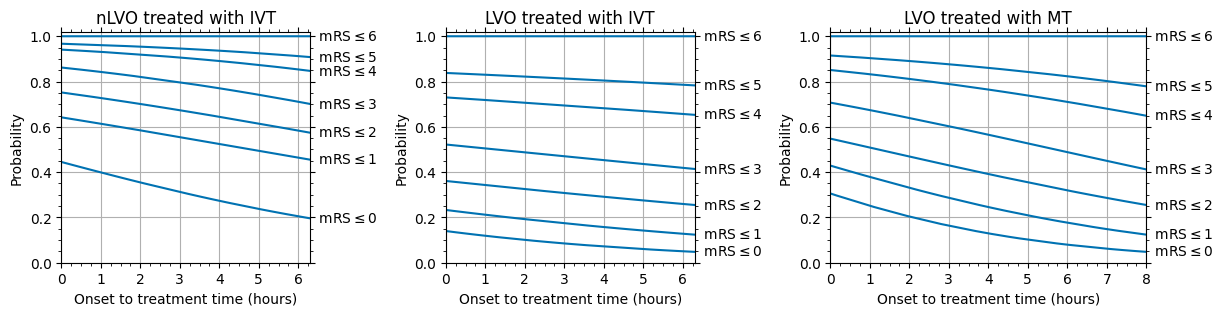

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3), gridspec_kw={'wspace': 0.5, 'width_ratios': [wr, wr, 1]})

dfs = [df_probs_nlvo_ivt, df_probs_lvo_ivt, df_probs_lvo_mt]
titles = ['nLVO treated with IVT', 'LVO treated with IVT', 'LVO treated with MT']

colour_line = colour_list[0]

for d, df in enumerate(dfs):
    ax = axs[d]

    # Convert minutes to hours:
    times = df.index.values / 60.0

    for i in range(7):
        probs = df[f'mRS<={i}'].values
        ax.plot(times, probs, color=colour_line)

        # Annotate the right-hand side of the line:
        ax.annotate(rf'  mRS$\leq${i}', xy=(times[-1], probs[-1]), ha='left', va='center')
        

for d, ax in enumerate(axs):
    ax.set_ylim(0.0, 1.02)

    xmax = 6.3 if d < 2 else 8.0
    ax.set_xlim(0.0, xmax)
    ax.set_xticks(np.arange(0, xmax + 0.01))
    ax.set_xticks(np.arange(0.0, xmax + 0.01, 0.25), minor=True)
    
    ax.set_yticks(np.arange(0.0, 1.01, 0.05), minor=True)
    ax.tick_params(right=True, top=True, which='both')
    ax.grid('on')
    ax.set_xlabel('Onset to treatment time (hours)')
    ax.set_ylabel('Probability')
    ax.set_title(titles[d])

plt.savefig(os.path.join(dir_images, 'probs_with_time_annotated.png'), bbox_inches='tight')
plt.show()